In [1]:
import os
import json
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 


from utils.vis import plot_images_nib, plot_images, analyze_inhale_exhale, plot_slice
from utils.preprocessing import hu_data, remove_gantry, apply_clahe, convert_signed_4bit_to_hu, convert_to_signed_4bit, fill_chest_cavity, convert_signed_4bit_to_unsigned_8bit, segment_kmeans
from utils.segment import apply_lungmask_binary, apply_lungmask_thresholded


In [9]:
DATA_PATH = './data'
RESULT_PATH = './results'
PARAMETER_PATH = './parameter'
ELASTIX_PATH = './elastix'
DATA_PATH_4BIT = './data_4bit'
MASK_PATH = './mask'
dataset_info = json.load(open("./data/dataset_info.json"))
save = False
vis = False

# Image Check

In [3]:
key = 'copd4'
inhale_image = nib.load(os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz'))
exhale_image = nib.load(os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz'))
inhale_data = inhale_image.get_fdata()
exhale_data = exhale_image.get_fdata()

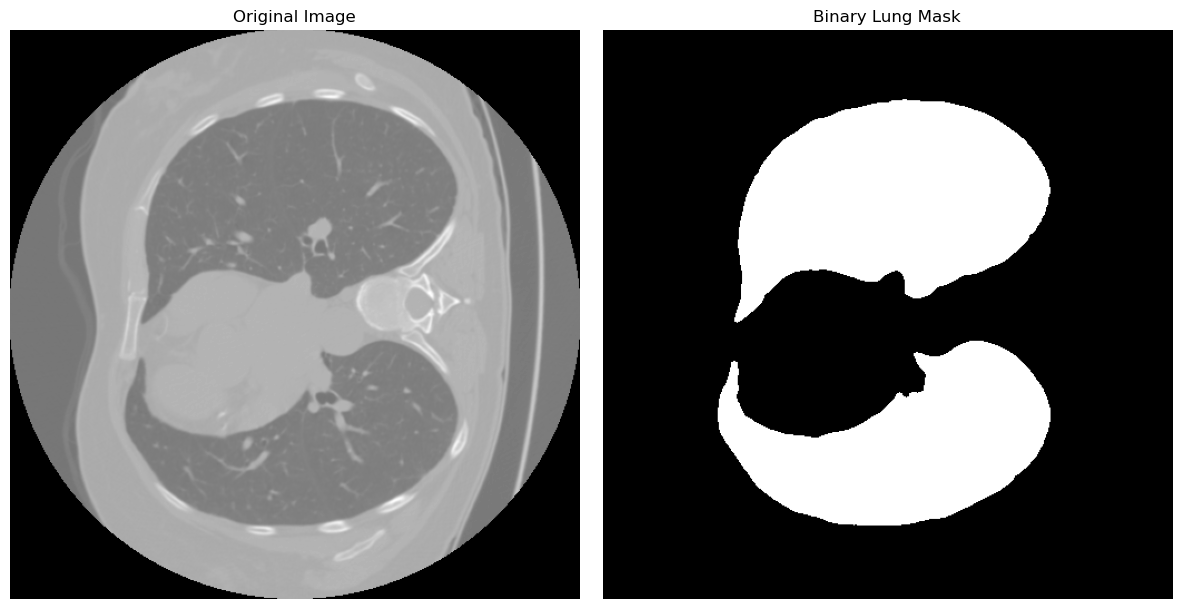

In [4]:
lung_new = apply_lungmask_thresholded(inhale_data, vis=True)

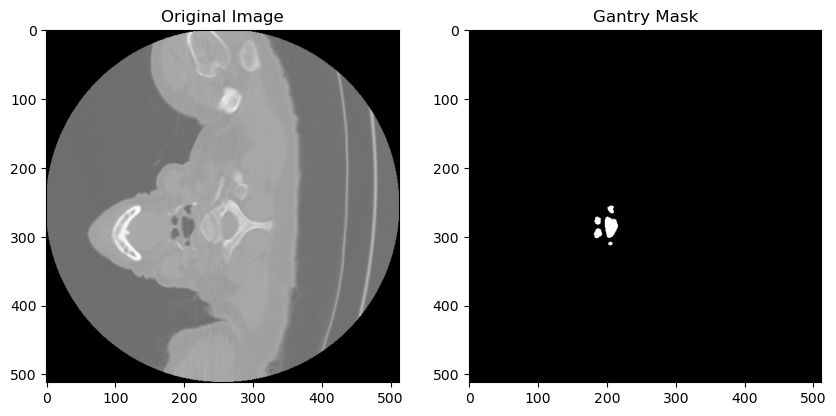

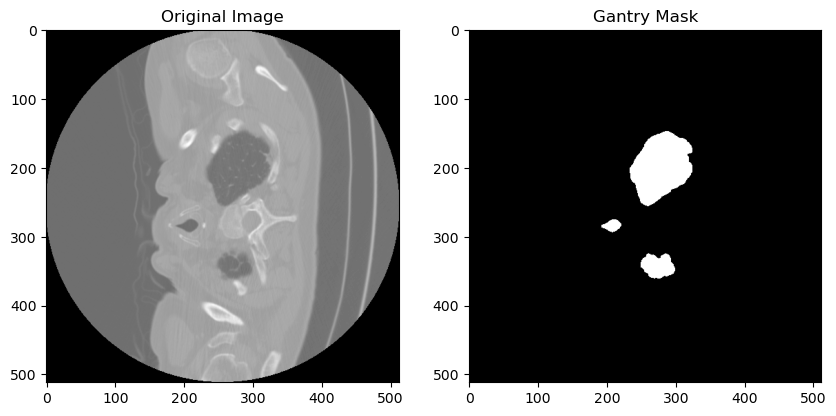

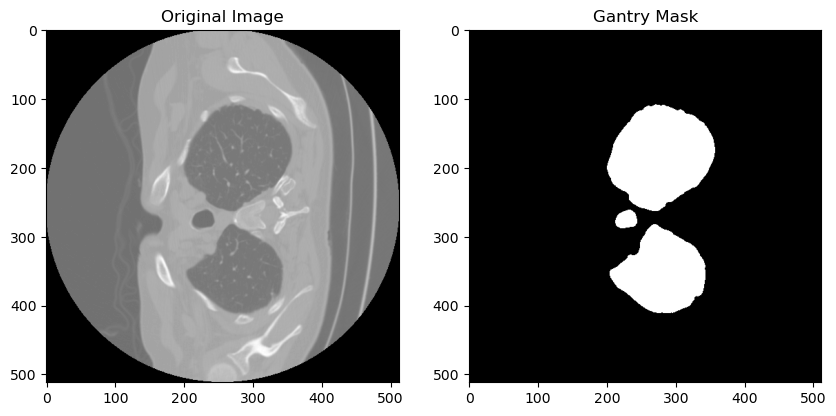

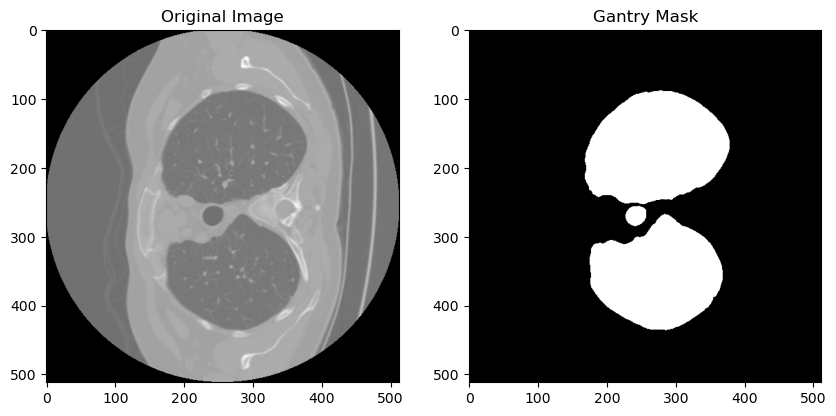

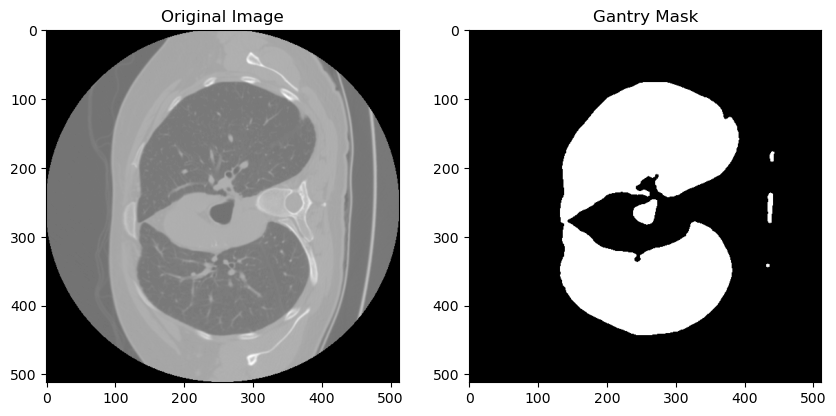

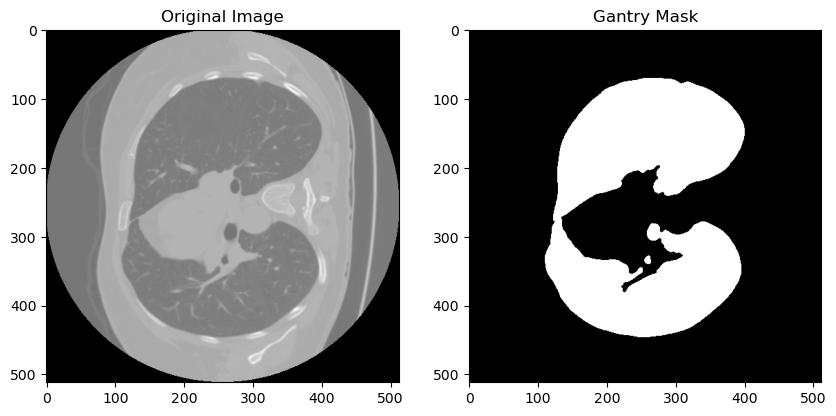

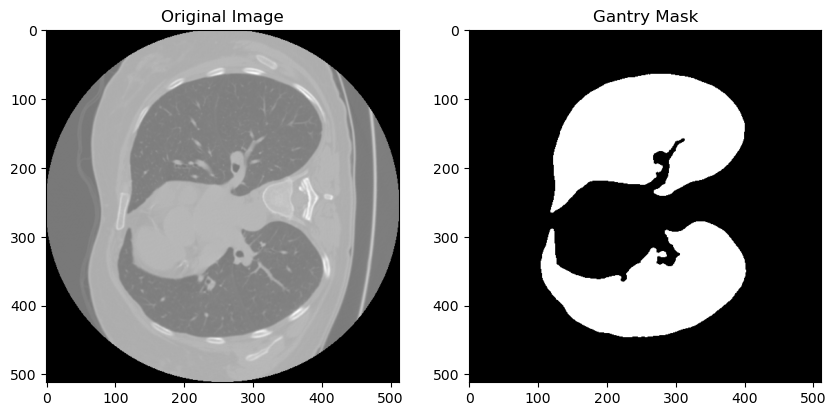

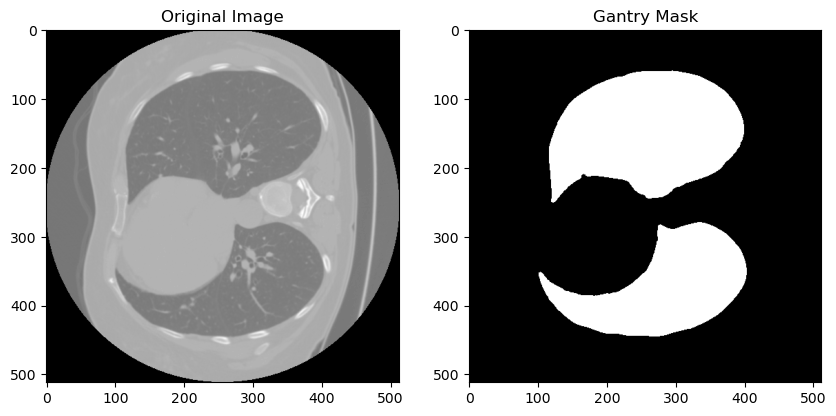

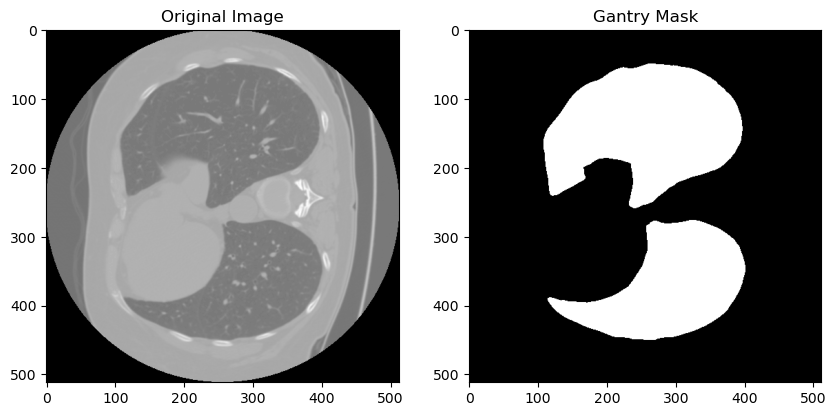

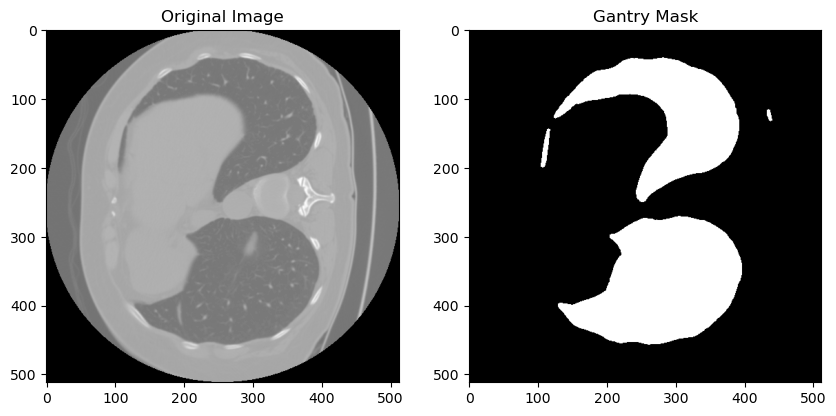

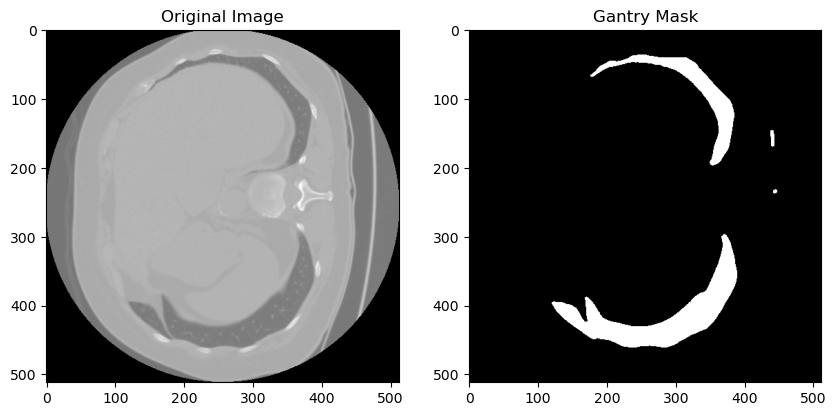

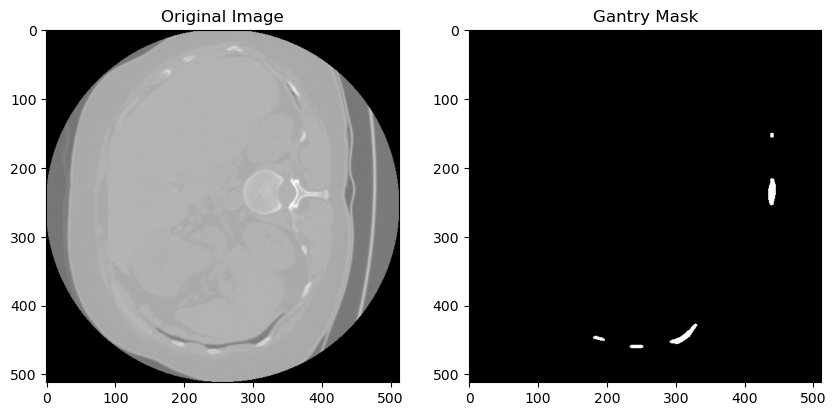

In [5]:
for i in range(0, 120, 10):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(inhale_data[:, :, i], cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(lung_new[:, :, i], cmap="gray")
        ax[1].set_title("Gantry Mask")
        plt.show()

In [4]:
if vis == True:
    plot_images_nib([inhale_image, exhale_image], titles=[f"{key} Inhale", f"{key} Exhale"], cols=2, slice_idx=50, fig_size=(10, 10))

In [5]:
if vis == True:
    analyze_inhale_exhale(inhale_data, exhale_data)

In [6]:
hu_inhale = hu_data(inhale_data)
hu_exhale = hu_data(exhale_data)

In [7]:
if vis == True:
    analyze_inhale_exhale(hu_inhale, hu_exhale)

In [8]:
if save == True:
    inhale_save = os.path.join(DATA_PATH, key, f'{key}_iBHCT_hu.nii.gz')
    exhale_save = os.path.join(DATA_PATH, key, f'{key}_eBHCT_hu.nii.gz')

    inhale_image_hu = nib.Nifti1Image(hu_inhale, inhale_image.affine)
    exhale_image_hu = nib.Nifti1Image(hu_exhale, exhale_image.affine)
    nib.save(inhale_image_hu, inhale_save)
    nib.save(exhale_image_hu, exhale_save)

In [9]:
bit_4 = convert_to_signed_4bit(hu_exhale)
bit_4_hu = convert_signed_4bit_to_hu(bit_4)
exhale_8 = convert_signed_4bit_to_unsigned_8bit(bit_4)

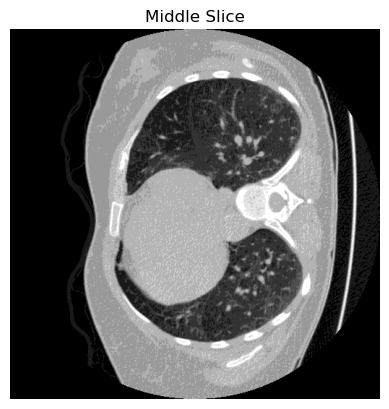

In [42]:
plot_slice(bit_4_hu)

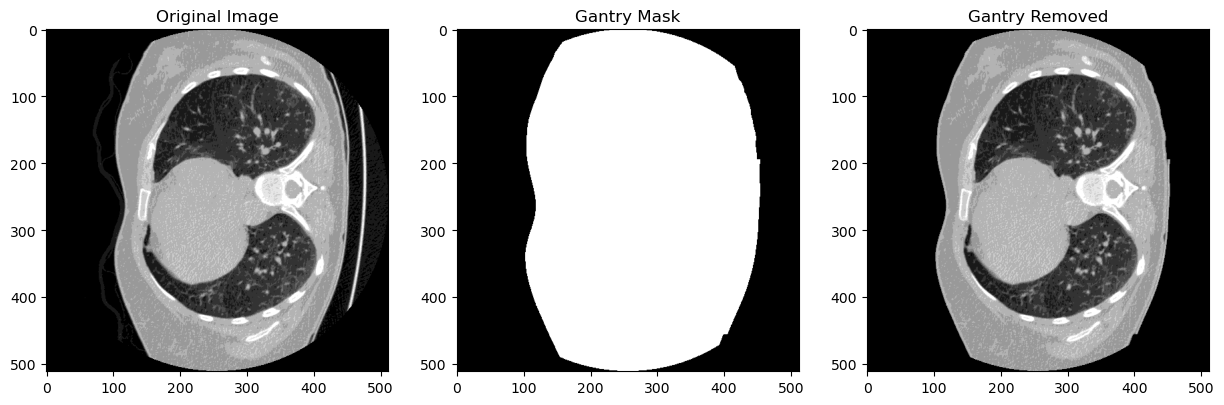

In [11]:
gantry_exhale, lung = remove_gantry(bit_4, visualize=True)

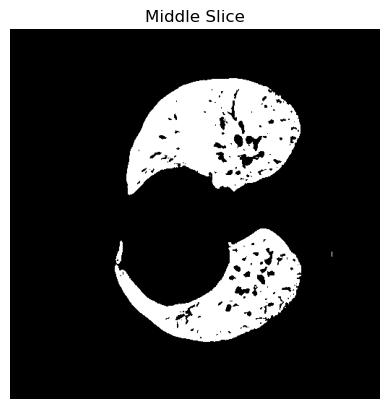

In [13]:
plot_slice(lung)

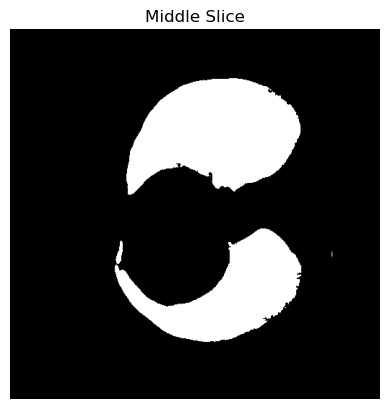

In [45]:
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import binary_closing
filled_mask = np.zeros_like(lung, dtype=np.uint8)
for z in range(lung.shape[2]):
    filled_mask[:, :, z] = binary_fill_holes(lung[:, :, z])
    
plot_slice(filled_mask)

In [17]:
seg = apply_lungmask_binary(exhale_data)

lungmask 2025-01-05 01:30:14 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


 98%|█████████▊| 25/25.6 [00:22<00:00,  1.11it/s]/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
102%|██████████| 26/25.6 [00:23<00:00,  1.11it/s]

lungmask 2025-01-05 01:30:39 Postprocessing



100%|██████████| 60/60 [00:01<00:00, 46.25it/s] 


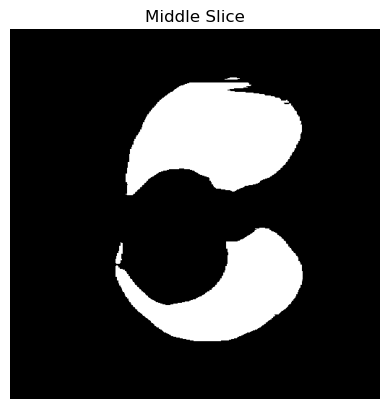

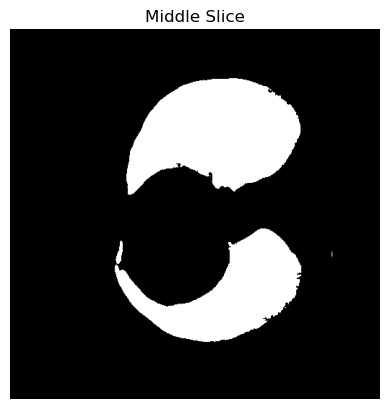

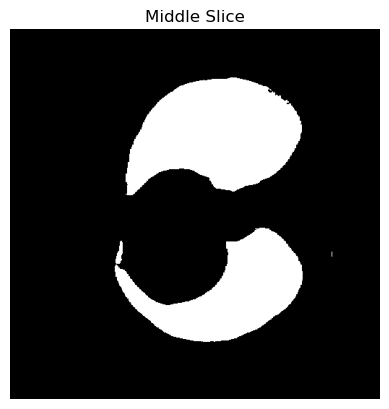

In [22]:
plot_slice(seg)
plot_slice(filled_mask)
plot_slice(np.bitwise_or(seg, filled_mask))

In [39]:
import numpy as np
from scipy.ndimage import binary_closing, generate_binary_structure
import matplotlib.pyplot as plt

def apply_binary_closing_3d(binary_image, structure_size=1):
    """
    Apply binary closing to a 3D binary image.

    Parameters:
        binary_image (numpy.ndarray): 3D binary image (values: 0 or 1).
        structure_size (int): Size of the structuring element for closing (default: 1).

    Returns:
        numpy.ndarray: Binary image after applying closing.
    """
    # Define a 3D structuring element (default: 3x3x3 cube)
    structuring_element = generate_binary_structure(3, structure_size)

    # Apply binary closing
    closed_image = binary_closing(binary_image, structure=structuring_element)

    return closed_image

def apply_binary_closing_custom_3d(binary_image, structure_size=5):
    """
    Apply binary closing to a 3D binary image with a custom structuring element.

    Parameters:
        binary_image (numpy.ndarray): 3D binary image (values: 0 or 1).
        structure_size (int): Size of the structuring element (must be odd, e.g., 5 or 9).

    Returns:
        numpy.ndarray: Binary image after applying closing.
    """
    if structure_size % 2 == 0:
        raise ValueError("Structuring element size must be an odd number.")

    # Create a cube-shaped structuring element of the given size
    structuring_element = np.ones((structure_size, structure_size, structure_size), dtype=bool)

    # Apply binary closing
    closed_image = binary_closing(binary_image, structure=structuring_element)

    return closed_image


In [40]:
seg_closed = apply_binary_closing_custom_3d(seg)

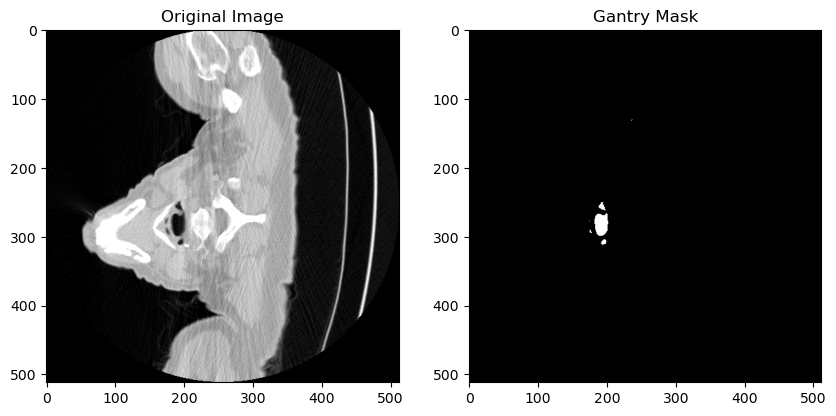

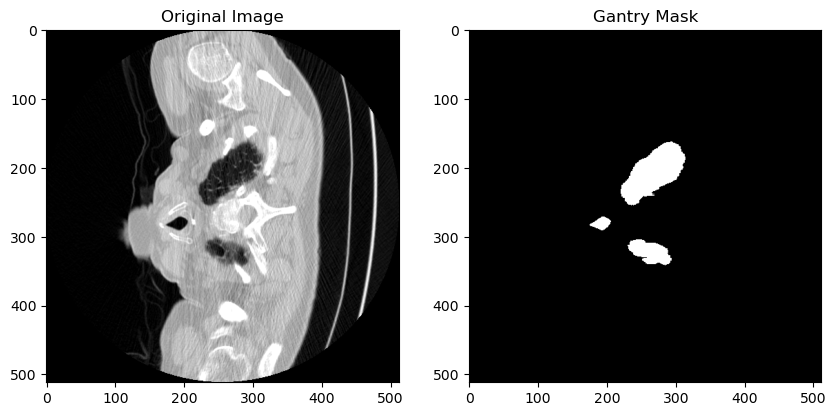

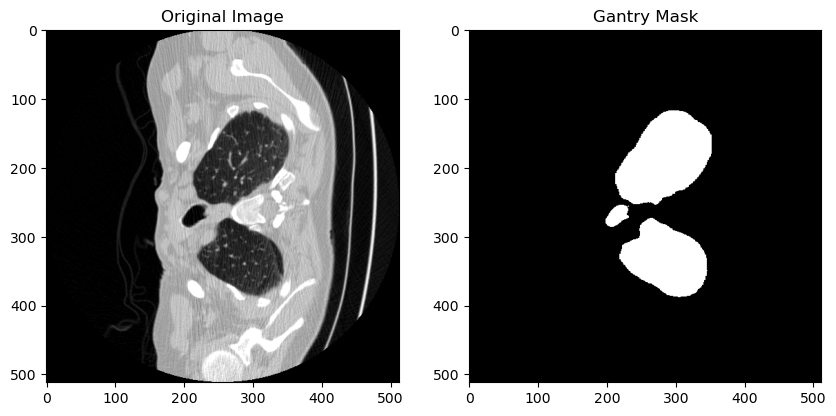

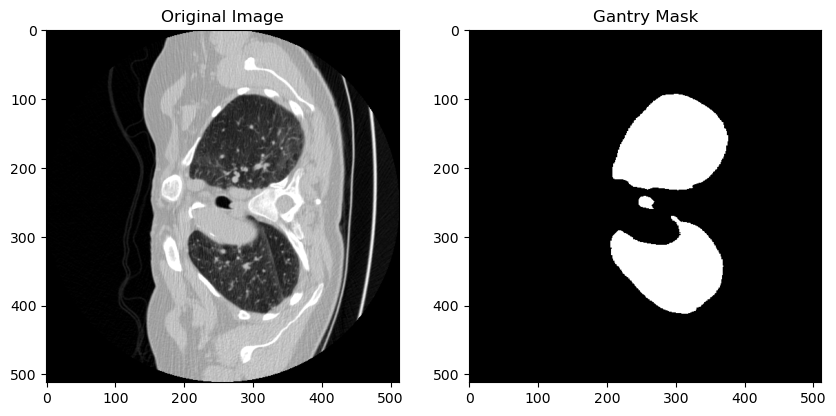

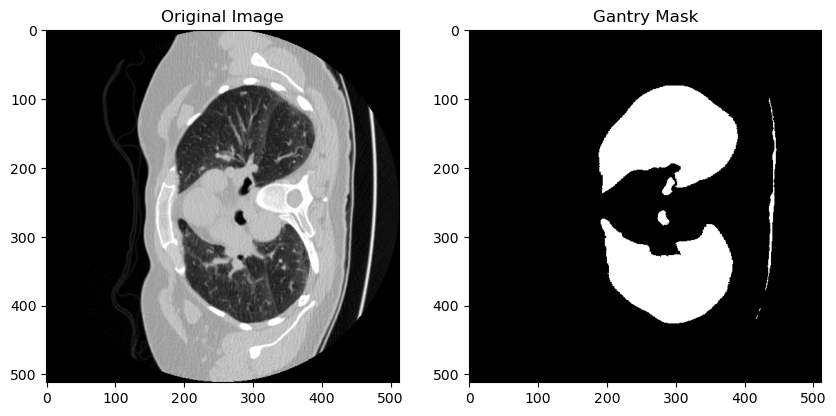

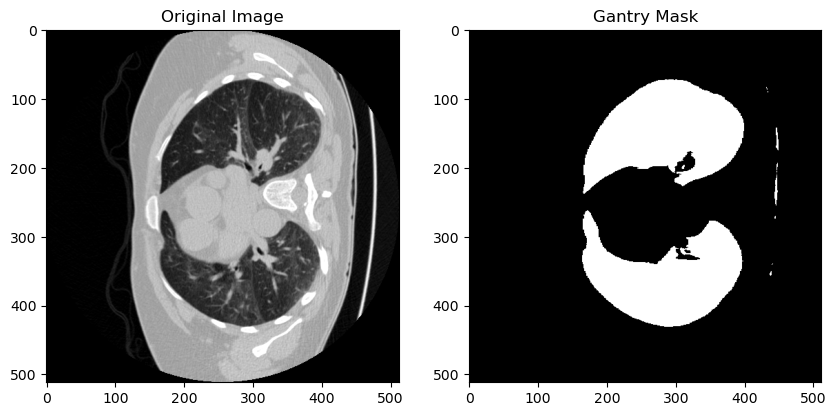

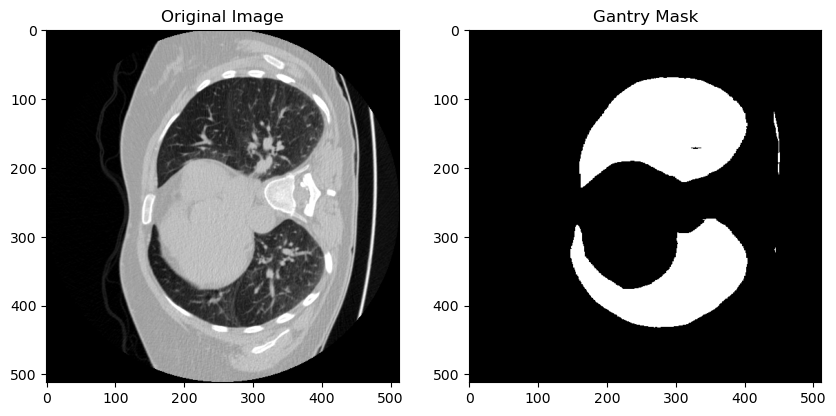

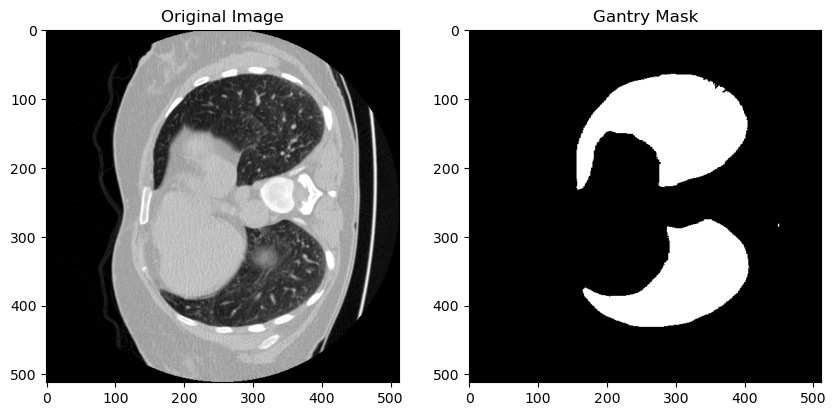

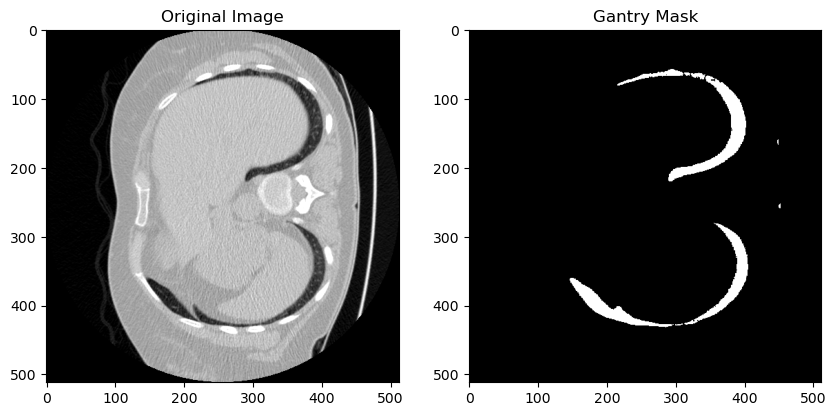

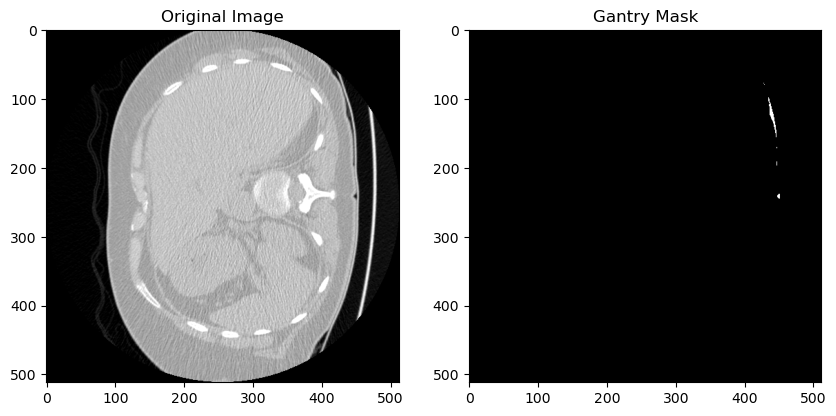

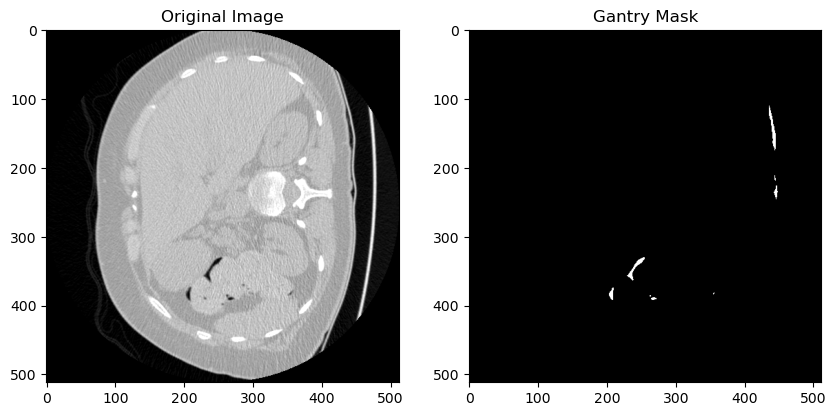

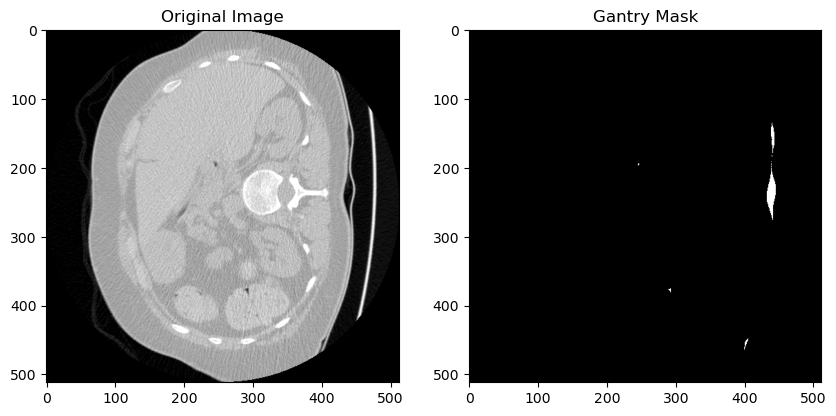

In [30]:
for i in range(0, 120, 10):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(hu_exhale[:, :, i], cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(np.bitwise_or(seg, filled_mask)[:, :, i], cmap="gray")
        ax[1].set_title("Gantry Mask")
        plt.show()

In [ ]:
_, threshold = cv2.threshold(convert_signed_4bit_to_unsigned_8bit(bit_4), 80, 255, cv2.THRESH_BINARY)

In [ ]:
threshold_ = np.bitwise_not(threshold)

# Loop for Images

In [11]:
for key, value in dataset_info.items():
    print(f"Processing {key}")
    
    ## Read the images
    inhale_image_path = os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz')
    exhale_image_path = os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz')
        
    inhale_image = nib.load(exhale_image_path)
    inhale_data = inhale_image.get_fdata()
    exhale_image = nib.load(exhale_image_path)
    exhale_data = exhale_image.get_fdata()

    ## Preprocess the images
    hu_inhale = hu_data(inhale_data)
    hu_exhale = hu_data(exhale_data)

    inhale_bit_4 = convert_to_signed_4bit(hu_inhale)
    exhale_bit_4 = convert_to_signed_4bit(hu_exhale)

    inhale_bit_4_hu = convert_signed_4bit_to_hu(inhale_bit_4)
    exhale_bit_4_hu = convert_signed_4bit_to_hu(exhale_bit_4)

    lung_inhale = apply_lungmask_binary(inhale_data)
    lung_exhale = apply_lungmask_binary(exhale_data)

    lung_inhale_threholded = apply_lungmask_thresholded(inhale_data)
    lung_exhale_threholded = apply_lungmask_thresholded(exhale_data)

    ## Export 4-bit hu images
    inhale_4bit_export_path = os.path.join(DATA_PATH_4BIT, key)
    exhale_4bit_export_path = os.path.join(DATA_PATH_4BIT, key)
    os.makedirs(inhale_4bit_export_path, exist_ok=True)
    os.makedirs(exhale_4bit_export_path, exist_ok=True)
    inhale_4bit_hu = nib.Nifti1Image(inhale_bit_4_hu, inhale_image.affine)
    exhale_4bit_hu = nib.Nifti1Image(exhale_bit_4_hu, exhale_image.affine)
    nib.save(inhale_4bit_hu, os.path.join(inhale_4bit_export_path, f'{key}_iBHCT_4bit.nii.gz'))
    nib.save(exhale_4bit_hu, os.path.join(exhale_4bit_export_path, f'{key}_eBHCT_4bit.nii.gz'))

    ## Export the lung masks
    lung_inhale_export_path = os.path.join(MASK_PATH, key)
    lung_exhale_export_path = os.path.join(MASK_PATH, key)
    os.makedirs(lung_inhale_export_path, exist_ok=True)
    os.makedirs(lung_exhale_export_path, exist_ok=True)
    lung_inhale_nib = nib.Nifti1Image(lung_inhale, inhale_image.affine)
    lung_exhale_nib = nib.Nifti1Image(lung_exhale, exhale_image.affine)
    nib.save(lung_inhale_nib, os.path.join(lung_inhale_export_path, f'{key}_iBHCT_lung_mask.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)
    nib.save(lung_exhale_nib, os.path.join(lung_exhale_export_path, f'{key}_eBHCT_lung_mask.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)

    ## Export the thresholded lung masks
    lung_inhale_thresholded_export_path = os.path.join(MASK_PATH, key)
    lung_exhale_thresholded_export_path = os.path.join(MASK_PATH, key)
    os.makedirs(lung_inhale_thresholded_export_path, exist_ok=True)
    os.makedirs(lung_exhale_thresholded_export_path, exist_ok=True)
    lung_inhale_thresholded_nib = nib.Nifti1Image(lung_inhale_threholded, inhale_image.affine)
    lung_exhale_thresholded_nib = nib.Nifti1Image(lung_exhale_threholded, exhale_image.affine)
    nib.save(lung_inhale_thresholded_nib, os.path.join(lung_inhale_thresholded_export_path, f'{key}_iBHCT_lung_mask_thresholded.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)    
    nib.save(lung_exhale_thresholded_nib, os.path.join(lung_exhale_thresholded_export_path, f'{key}_eBHCT_lung_mask_thresholded.nii.gz'))
    print('*'*50, 'lung mask saved', '*'*50)   
    

Processing copd1
lungmask 2025-01-06 04:13:36 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


 98%|█████████▊| 25/25.6 [00:23<00:00,  1.11it/s]/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-06 04:14:02 Postprocessing



100%|██████████| 104/104 [00:02<00:00, 50.47it/s]


lungmask 2025-01-06 04:14:08 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.10it/s]

lungmask 2025-01-06 04:14:34 Postprocessing



100%|██████████| 104/104 [00:02<00:00, 50.83it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd2
lungmask 2025-01-06 04:15:02 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-06 04:15:28 Postprocessing



100%|██████████| 149/149 [00:02<00:00, 51.56it/s]


lungmask 2025-01-06 04:15:34 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-06 04:16:01 Postprocessing



100%|██████████| 149/149 [00:02<00:00, 52.20it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd3
lungmask 2025-01-06 04:16:27 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-06 04:16:53 Postprocessing



100%|██████████| 123/123 [00:03<00:00, 40.29it/s]


lungmask 2025-01-06 04:17:00 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.10it/s]

lungmask 2025-01-06 04:17:26 Postprocessing



100%|██████████| 123/123 [00:03<00:00, 40.78it/s]


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
Processing copd4
lungmask 2025-01-06 04:17:58 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.09it/s]

lungmask 2025-01-06 04:18:24 Postprocessing



100%|██████████| 60/60 [00:01<00:00, 44.36it/s] 


lungmask 2025-01-06 04:18:29 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


102%|██████████| 26/25.6 [00:23<00:00,  1.10it/s]

lungmask 2025-01-06 04:18:55 Postprocessing



100%|██████████| 60/60 [00:01<00:00, 46.54it/s] 


************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
************************************************** lung mask saved **************************************************
